In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from time import sleep

In [2]:
import re
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [3]:
from scipy.sparse.linalg import svds
from numpy import argsort
from numpy import diag

In [4]:
from numpy.linalg import norm
from numpy import zeros
from  numpy import ndarray

In [24]:
from scipy.sparse import save_npz, load_npz

### 1. Scrape or download dataset
It came out that every complaint has its own page and the pages are sequentially numbered: http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/{page_num}. The numbers are in range between 60 and 12700.

In [5]:
def scrape(out_file: str):
    df = pd.DataFrame(columns=('number', 'appeal', 'appeal_date', 'response', 'response_date'))
    log = []
    for page_num in range(6365, 12739):
        try:
            url = f'http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/{page_num}'
            page = requests.get(url)
            if page.url == url:
                soup = BeautifulSoup(page.text, 'html.parser')
                appeal =soup.find('p', attrs={'class': "appeal-details-message"}).text
                appeal_date = soup.find('p', attrs={'class': "appeal-element-bottom"}).text
                response = soup.find('p', attrs={'class': "appeal-comments-message"}).text
                response_date = soup.find('p', attrs={'class': "appeal-comments-date"}).text
                case = {'number': page_num,
                        'appeal': appeal,
                        'appeal_date': appeal_date,
                        'response': response,
                        'response_date': response_date}
                df = df.append(case, ignore_index=True)
                print(page_num)
            else:
                print('missed')
        except Exception as err:
            log.append((page_num, err))
        sleep(0.5)
    df.to_csv(out_file)

In [6]:
df = pd.read_csv('RPNfull.csv')

### 2. Preprocessing

In [7]:
stemmer = Mystem()
def preprocess(text):
    # strip all non-alphabetical characaters
    text = re.sub('[^А-яA-z]', ' ', text)
    new_text = []
    for char in range(len(text)):
        if (text[char] == ' ') and (text[char-1] == ' '):
            pass
        else:
            new_text.append(text[char])
    text = ''.join(new_text)
    # tokenize and lemmatize
    tokens = [word for word in stemmer.lemmatize(text) if ((word != ' ') and (word != ' \n'))]
    return ' '.join(tokens)

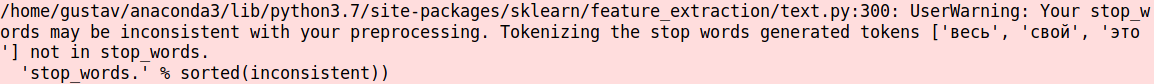

In [8]:
# download nltk stopwords for Russian language
upd_stopwords = stopwords.words('russian')
# stop words defined by vectorizer
upd_stopwords.extend(['весь', 'свой', 'это'])
# stop words defined after topic analysis
upd_stopwords.extend(['год', 'день', 'который'])
upd_stopwords.extend(['дом', 'сказать'])
print(upd_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

### 3. Vectorization

In [9]:
# vectorize the corpus, df.appeal
# counter = CountVectorizer(preprocessor=preprocess, stop_words=upd_stopwords)
# matrix = counter.fit_transform(list(df.appeal))
matrix = load_npz('matrix.npz')

In [25]:
# save the matrix
save_npz('matrix.npz', matrix)

In [11]:
# count word occurencies
wordcounts = matrix.sum(axis=0)
wordcounts = wordcounts.tolist()[0]
wordcounts = [(key, wordcounts[number]) for key, number in counter.vocabulary_.items()]
wordcounts.sort(key=lambda x: x[1], reverse=True)

In [12]:
wordcounts

[('магазин', 7130),
 ('товар', 6136),
 ('данный', 4703),
 ('телефон', 4006),
 ('деньги', 3969),
 ('просить', 3932),
 ('услуга', 3621),
 ('договор', 3591),
 ('мочь', 3546),
 ('адрес', 3232),
 ('вернуть', 3099),
 ('возврат', 3098),
 ('обращаться', 2824),
 ('добрый', 2773),
 ('компания', 2769),
 ('продавец', 2757),
 ('получать', 2581),
 ('ответ', 2486),
 ('право', 2446),
 ('средство', 2403),
 ('сайт', 2373),
 ('вопрос', 2159),
 ('здравствовать', 2158),
 ('срок', 2131),
 ('ул', 2115),
 ('рубль', 2105),
 ('время', 2072),
 ('ситуация', 2043),
 ('принимать', 2031),
 ('ооо', 2013),
 ('интернет', 1977),
 ('ремонт', 1963),
 ('претензия', 1952),
 ('заявление', 1911),
 ('отказываться', 1873),
 ('сумма', 1860),
 ('должный', 1859),
 ('работа', 1845),
 ('потребитель', 1819),
 ('заказ', 1818),
 ('купить', 1807),
 ('отвечать', 1767),
 ('оплачивать', 1767),
 ('сотрудник', 1729),
 ('указывать', 1689),
 ('связь', 1643),
 ('обращение', 1640),
 ('сделать', 1636),
 ('написать', 1631),
 ('номер', 1630),
 ('ин

In [13]:
# make words searchable by their position in the dictionary
my_vocab = {number: word for word, number in counter.vocabulary_.items()}

### 4. LSI (Latent Symantic Analysis) with SVD

In [19]:
# svd-decompose the wordcount matrix to retrieve prevalent word combintaions aka topics
U, S, VT = svds(matrix.asfptype(), k=20)

In [20]:
# multiply S with VT
SVT = diag(S) @ VT

In [21]:
# represent the topics as the words they consist of
topics = []
i = 0
for row in argsort(VT, axis=1):
    topics.append([(SVT[i][word], my_vocab[word]) for word in row[-10:]])
    i += 1
topics

[[(10.169021095145418, 'оператор'),
  (10.91059249824966, 'телефон'),
  (12.24792372811788, 'доставка'),
  (13.197874556728578, 'наш'),
  (14.075509330225263, 'вода'),
  (14.525012457765726, 'денежный'),
  (15.28077651676814, 'ребенок'),
  (16.257288762009363, 'средство'),
  (17.285004985947058, 'заказ'),
  (23.16717972222489, 'квартира')],
 [(6.151538008902494, 'территория'),
  (6.929060513535189, 'медицинский'),
  (7.3135657759598836, 'номер'),
  (8.01963387371722, 'сотрудник'),
  (9.535214261759997, 'возврат'),
  (10.156930187789213, 'мочь'),
  (12.334209382693109, 'телефон'),
  (14.017433173860644, 'ребенок'),
  (15.007617419504546, 'ооо'),
  (27.04854893000847, 'товар')],
 [(8.780491076090467, 'связь'),
  (9.103416193361426, 'деньги'),
  (9.568719817905759, 'ребенок'),
  (9.919310227664155, 'оператор'),
  (10.260996715044572, 'доставка'),
  (10.63028996387359, 'данный'),
  (12.097670611739114, 'мочь'),
  (17.68737330793727, 'сайт'),
  (19.71657528443401, 'заказ'),
  (25.4518181280

In [17]:
def text_as_topics(text: str, vectorizer: CountVectorizer, SVT: ndarray) -> ndarray:
    
    """Compute approximate topic representation for the text"""
    
    coefficients = zeros((len(SVT), 1))
    # vectorize text
    vector = counter.transform([text])
    # project text onto the topics from SVT
    for row in range(len(SVT)):
        projection = vector @ SVT[row].reshape(-1, 1) / norm(SVT[row], ord=1)
        coefficients[row, 0] = projection
    return coefficients

def show_topics(coefficients, topics):
    
    """Verbose top-5 topics"""
    
    for topic in argsort(coefficients, axis=0)[-1:-6:-1]:
        top = (topic[0], coefficients[topic][0][0], [row[1] for row in topics[topic[0]]])
        print(top)

In [18]:
# example topic modelling
text = df.appeal[6859]
print(text)
coefs = text_as_topics(text, counter, SVT)
show_topics(coefs, topics)
# compare topic coeffs with the coeffs from the U-matrix
print(argsort(U[0])[-1:-6:-1])

02.08 была привезена стиральная машина (доставка + подъем на 3 этаж без лифта).
03.08 при тестовых прогонах нами была обнаружена течь снизу. В этот же день обратились на Горячую линию с проблемой, нам было рекомендовано обратиться в сервисный центр, что мы и сделали. Мастер приехал 7.08 и обнаружил проблему - трещину на Баке. После чего мы обратились снова в Ситилинк, так как ремонт негарантийный. После многочисленных звонков с напоминанием о нашей проблеме - нам в итоге пришел отказ, мотивированный тем что при приеме товара у нас не было претензий к внешнему виду... Претензий к внешнему виду действительно нет. Но каким образом мы могли увидеть трещину на баке?! Просьба оказать помощь в решении данной ситуации.
(23, 0.04564983600859671, ['интернет', 'доставка', 'заказ', 'вернуть', 'деньги', 'продавец', 'телефон', 'возврат', 'магазин', 'товар'])
(13, 0.040799259999158816, ['наш', 'ооо', 'квартира', 'мастер', 'мочь', 'ребенок', 'ремонт', 'автомобиль', 'работа', 'договор'])
(19, 0.0391156